## Time Series Part A, Monthly Temperature data

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import math
from math import sqrt
#Visualization Phase
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as pylab
%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load the temperature dataframe
df = pd.read_csv("nitm18442004.csv")

# define the start and end dates
start_date = '1844-01-01'
end_date = '2004-12-31'

# create a dataframe with date range
df_dates = pd.DataFrame(pd.date_range(start=start_date, end=end_date, freq='M'), columns=['date'])

# concatenate the dataframes on date column
df_concat = pd.concat([df_dates, df['x']], axis=1)

# print the concatenated dataframe
print(df_concat)

           date     x
0    1844-01-31   4.5
1    1844-02-29   2.4
2    1844-03-31   4.8
3    1844-04-30   9.1
4    1844-05-31  10.9
...         ...   ...
1927 2004-08-31  15.4
1928 2004-09-30  13.2
1929 2004-10-31   8.6
1930 2004-11-30   8.2
1931 2004-12-31   6.2

[1932 rows x 2 columns]


In [3]:
df_concat.head()

,date,x
0,1844-01-31,4.5
1,1844-02-29,2.4
2,1844-03-31,4.8
3,1844-04-30,9.1
4,1844-05-31,10.9


In [4]:
df_concat.rename(columns={'x':'temperature'},inplace=True)

In [5]:
df_concat.head()

,date,temperature
0,1844-01-31,4.5
1,1844-02-29,2.4
2,1844-03-31,4.8
3,1844-04-30,9.1
4,1844-05-31,10.9


## Visualisation

## 1.Frequency of temperature

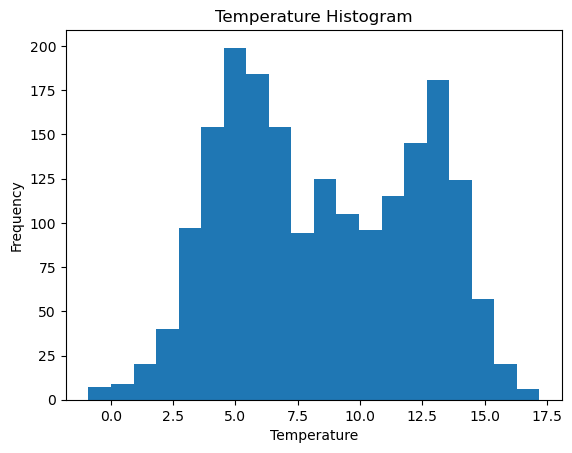

In [6]:
plt.hist(df_concat['temperature'], bins=20)

# set the title and axis labels
plt.title('Temperature Histogram')
plt.xlabel('Temperature')
plt.ylabel('Frequency')

# display the plot
plt.show()

## 2.Rolling mean and standard deviation

In [7]:
## determine rolling stat
rolmean=df_concat.rolling(window=12).mean()
rolstd=df_concat.rolling(window=12).std()
# print(rolmean,rolstd)

In [8]:
df_concat.head(2)

,date,temperature
0,1844-01-31,4.5
1,1844-02-29,2.4


In [9]:
df_concat['year'] = df_concat['date'].dt.year

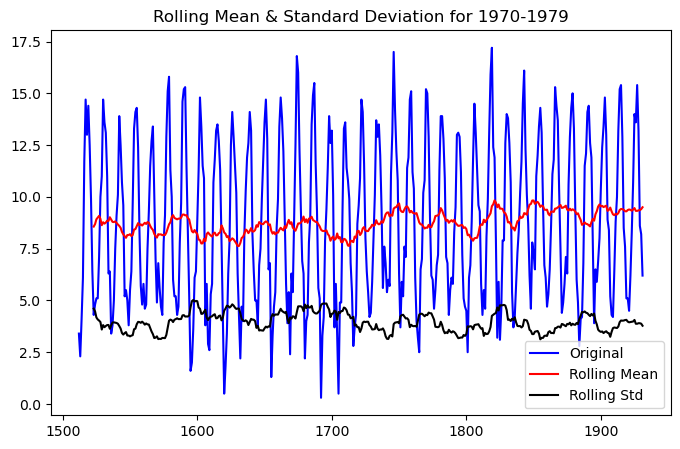

In [10]:
df_decade = df_concat[df_concat['year'] >= 1970]

window_size = 12
rolling_mean = df_decade['temperature'].rolling(window_size).mean()
rolling_std = df_decade['temperature'].rolling(window_size).std()

plt.figure(figsize=(8,5))
plt.plot(df_decade['temperature'], color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation for 1970-1979')
plt.show()

## Check the stationality

In [11]:
def ad_test(dataset):
    dftest=adfuller(dataset,autolag='AIC')
    print("ADF: ",dftest[0])
    print("P-value: ",dftest[1])
    print("No. of lags: ",dftest[2])
    print("No. of observation used for ADF Regression and critical value calculation: ",dftest[3])
    print("critical value: ")
    for key, val in dftest[4].items():
        print("\t",key, ": ",val)

In [12]:
ad_test(df_concat['temperature'].values)

ADF:  -5.000623974120449
P-value:  2.213013539022366e-05
No. of lags:  26
No. of observation used for ADF Regression and critical value calculation:  1905
critical value: 
	 1% :  -3.433787340386774
	 5% :  -2.8630583903440656
	 10% :  -2.567578333092222


## Define the training and test sets


In [13]:
df_concat.drop('year',axis=1,inplace=True)

In [14]:
df_concat.index = pd.to_datetime(df_concat['date'])
df_concat = df_concat.drop('date', axis=1)

In [15]:
train = pd.DataFrame(df_concat.loc[:'2003-12-31', 'temperature'])
test = pd.DataFrame(df_concat.loc['2004-01-31':, 'temperature'])

## 1.Exponential Smoothing

In [16]:
mode_exp = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)
fit_exp = mode_exp.fit()

In [17]:
predictions = fit_exp.predict(start='2004-01-31', end='2004-12-31')

In [18]:
## calculate the mean absolute error (MAE) and root mean squared error (RMSE) and mean_squared_error(MSE)
rmse = sqrt(mean_squared_error(predictions, test))
mae = mean_absolute_error(predictions, test)
mse = mean_squared_error(predictions, test)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:",rmse)

MAE: 0.6954856772225945
MSE: 0.6183767984558816
RMSE: 0.78636937787269


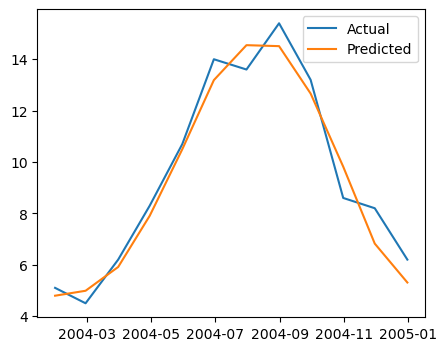

In [19]:
plt.figure(figsize=(5,4))
plt.plot(test.index, test, label='Actual')
plt.plot(predictions.index, predictions, label='Predicted')
plt.legend()
plt.show()

## 2. ARIMA

In [20]:
stepwise_fit=auto_arima(df_concat['temperature'],trace=True,suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7213.220, Time=3.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8925.234, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8665.314, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8742.518, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8923.234, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.85 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8618.863, Time=0.94 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6971.977, Time=3.27 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.88 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=6.40 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=7214.448, Time=4.87 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=4.73 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=4.39 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=6693.571, Time=5.04 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=6.95 s

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1932
Model:               SARIMAX(4, 1, 3)   Log Likelihood               -3337.786
Date:                Thu, 11 May 2023   AIC                           6693.571
Time:                        22:10:24   BIC                           6743.664
Sample:                    01-31-1844   HQIC                          6711.997
                         - 12-31-2004                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0026      0.001      2.630      0.009       0.001       0.004
ar.L1          1.9342      0.044     44.302      0.000       1.849       2.020
ar.L2         -1.3324      0.071    -18.758      0.000      -1.472      -1.193
ar.L3          0.1762      0.063      2.798      0.005       0.053       0.300
ar.L4          0.0182      0.036      0.500      0.617      -0.053       0.089
ma.L1         -2.5463      0.038    -66.711      0.000      -2.621      -2.471
ma.L2          2.3788      0.068     35.015      0.000       2.246       2.512
ma.L3         -0.8156      0.034    -23.696      0.000      -0.883      -0.748
sigma2         2.2513      0.089     25.417      0.000       2.078       2.425
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                21.52
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.18
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
model_arima=ARIMA(train,order=(4,1,3))
model_arima=model_arima.fit()
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            temperature   No. Observations:                 1920
Model:                 ARIMA(4, 1, 3)   Log Likelihood               -3244.583
Date:                Thu, 11 May 2023   AIC                           6505.166
Time:                        22:10:27   BIC                           6549.642
Sample:                    01-31-1844   HQIC                          6521.531
                         - 12-31-2003                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8996      0.029     65.975      0.000       1.843       1.956
ar.L2         -1.2413      0.050    -24.732      0.000      -1.340      -1.143
ar.L3          0.0844      0.048      1.764      0.078      -0.009       0.178
ar.L4          0.0503      0.026      1.912      0.056      -0.001       0.102
ma.L1         -2.6031      0.023   -113.284      0.000      -2.648      -2.558
ma.L2          2.4716      0.041     60.837      0.000       2.392       2.551
ma.L3         -0.8555      0.020    -42.097      0.000      -0.895      -0.816
sigma2         1.6349      0.050     32.984      0.000       1.538       1.732
===================================================================================
Ljung-Box (L1) (Q):                   3.33   Jarque-Bera (JB):                21.38
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -0.18
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
start=len(train)
end=len(train)+len(test)-1
pred=model_arima.predict(start=start,end=end,typ='levels')
print(pred)

2004-01-31     4.464531
2004-02-29     4.747929
2004-03-31     6.207740
2004-04-30     8.449632
2004-05-31    10.888155
2004-06-30    12.874834
2004-07-31    13.884263
2004-08-31    13.654126
2004-09-30    12.254181
2004-10-31    10.065619
2004-11-30     7.677391
2004-12-31     5.727782
Freq: M, Name: predicted_mean, dtype: float64


In [23]:
rmse = sqrt(mean_squared_error(pred, test))
mae = mean_absolute_error(test, pred)
mse = mean_squared_error(test, pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:",rmse)

MAE: 0.6492076791575118
MSE: 0.7047286050375284
RMSE: 0.8394811522824848


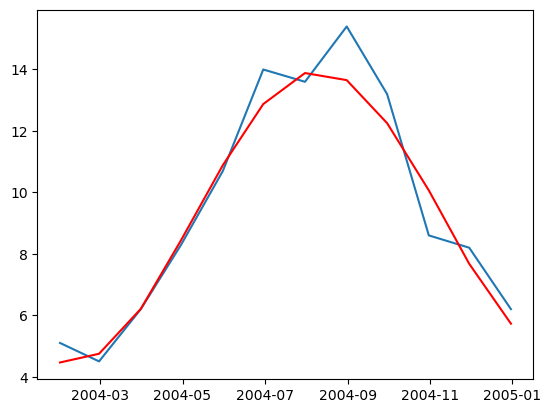

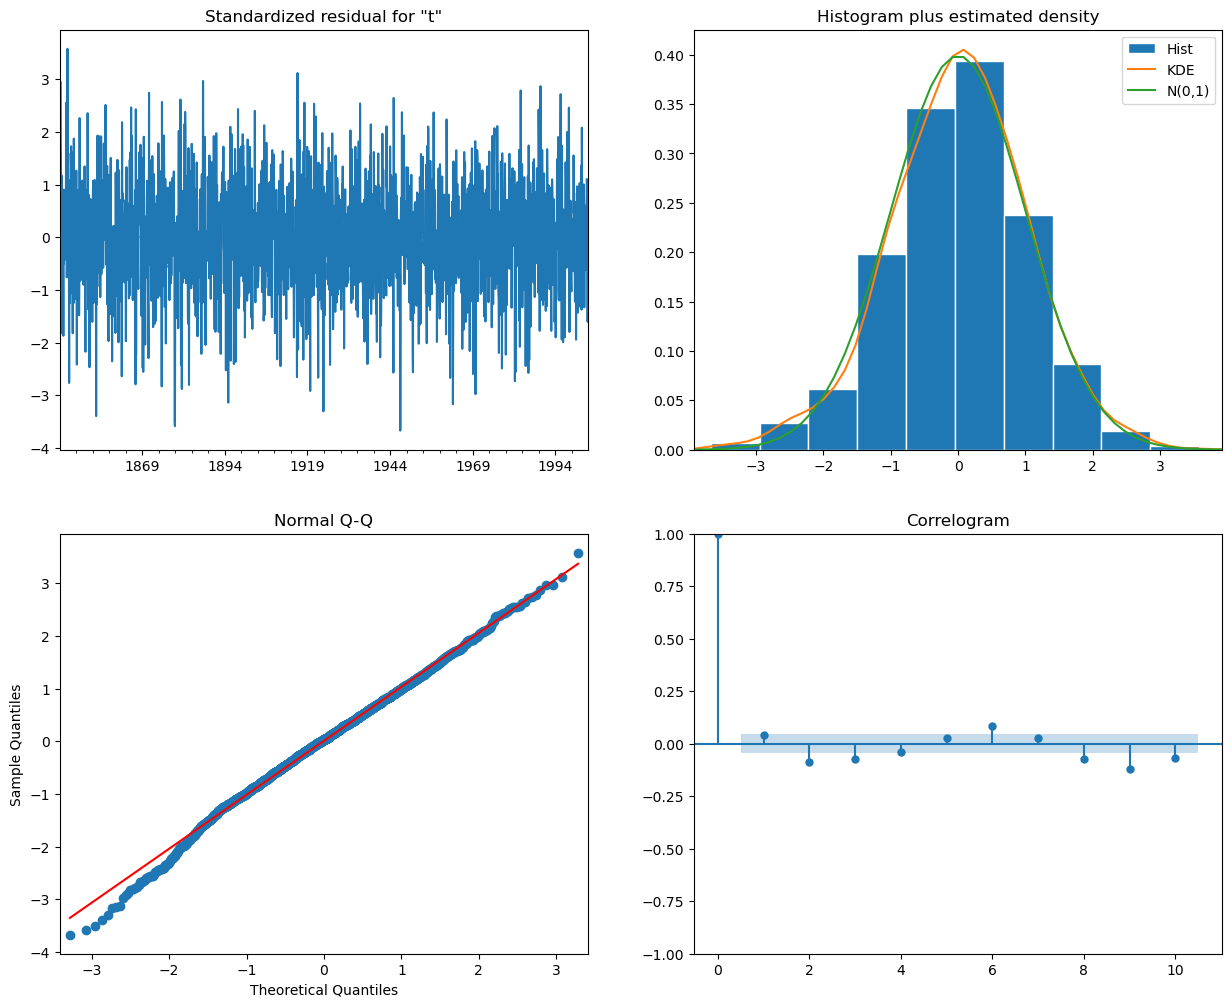

In [24]:
# Plot the predictions
plt.plot(test)
plt.plot(pred, color='red')
plt.show()

# Plot the model diagnostics
model_arima.plot_diagnostics(figsize=(15,12))
plt.show()

## 3. Arima AIC

In [25]:
model2 = ARIMA(train, order=(4,1,3))
model_fit = model2.fit()

In [26]:
train_aic = model_fit.aic

In [27]:
test_residuals = test - pred
test_sse = np.sum(test_residuals**2)
test_n = len(test_residuals)
test_aic = test_n * np.log(test_sse/test_n) + 2 * (4+1+3)/test_n

In [28]:
mse = mean_squared_error(test.temperature, pred)
mae = mean_absolute_error(test.temperature, pred)
rmse = math.sqrt(mse)

print("MSE: ", mse)
print("MAE: ", mae)
print("RMSE: ", rmse)

MSE:  0.7047286050375284
MAE:  0.6492076791575118
RMSE:  0.8394811522824848


## 4.Sarima

In [29]:
models = SARIMAX(train, order=(4,1,3), seasonal_order=(1, 1, 1, 12))
model_fits = models.fit()
print(model_fits.summary())

                                      SARIMAX Results                                       
Dep. Variable:                          temperature   No. Observations:                 1920
Model:             SARIMAX(4, 1, 3)x(1, 1, [1], 12)   Log Likelihood               -3063.594
Date:                              Thu, 11 May 2023   AIC                           6147.188
Time:                                      22:10:47   BIC                           6202.721
Sample:                                  01-31-1844   HQIC                          6167.628
                                       - 12-31-2003                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7607      0.059    -12.928      0.000      -0.876      -0.645
ar.L2         -0.71

In [30]:
start=len(train)
end=len(train)+len(test)-1
pred=model_fits.predict(start=start,end=end,typ='levels')
print(pred)

2004-01-31     4.498688
2004-02-29     4.771231
2004-03-31     6.093450
2004-04-30     7.682082
2004-05-31    10.442030
2004-06-30    13.044732
2004-07-31    14.491821
2004-08-31    14.536885
2004-09-30    12.686916
2004-10-31     9.890567
2004-11-30     6.859391
2004-12-31     5.326095
Freq: M, Name: predicted_mean, dtype: float64


In [31]:
rmse = sqrt(mean_squared_error(pred, test))
mae = mean_absolute_error(test, pred)
mse = mean_squared_error(test, pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:",rmse)

MAE: 0.7152791634366379
MSE: 0.6531229971059352
RMSE: 0.8081602545943071


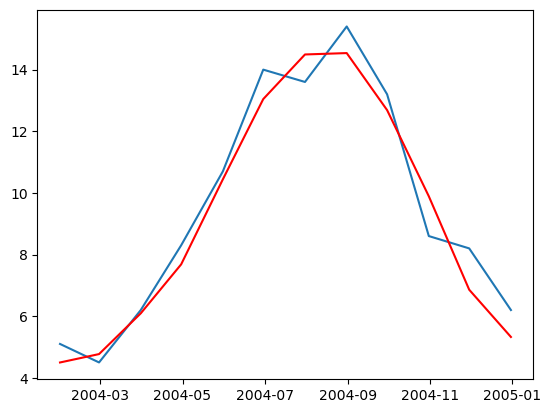

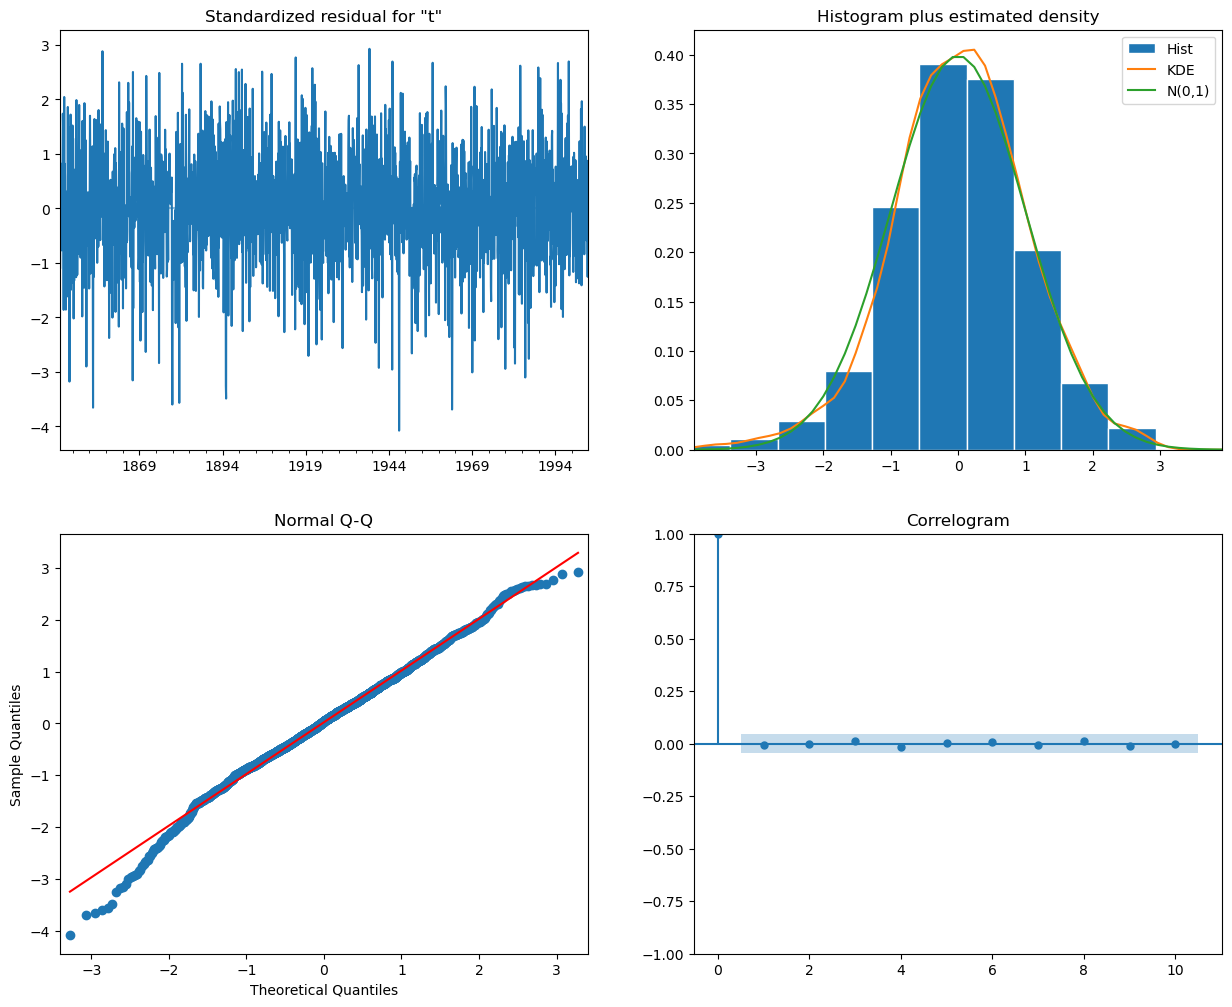

In [32]:
plt.plot(test)
plt.plot(pred, color='red')
plt.show()

# Plot the model diagnostics
model_fits.plot_diagnostics(figsize=(15,12))
plt.show()

## 5.Simple time series model - Seasonal Naive

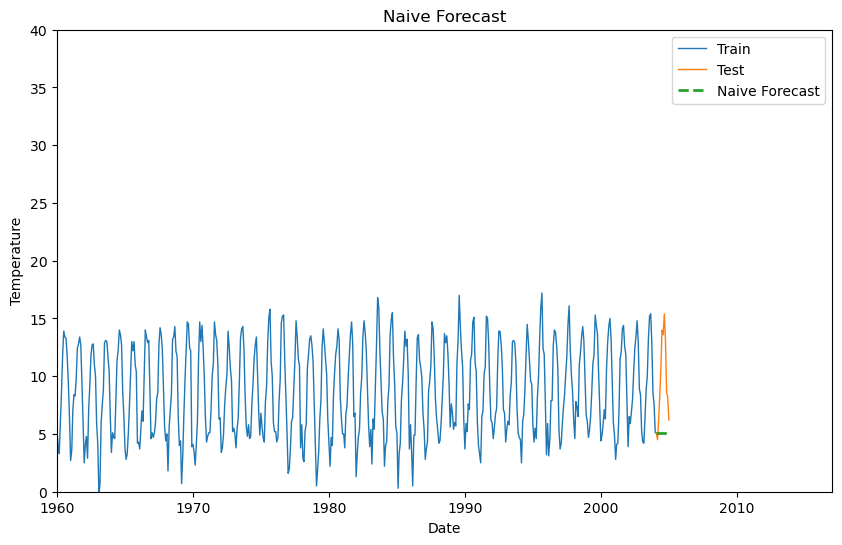

In [33]:
dd = np.asarray(train.temperature)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['temperature'], label='Train', linestyle='-', linewidth=1)
plt.plot(test.index, test['temperature'], label='Test', linestyle='-', linewidth=1)
plt.plot(y_hat.index, y_hat['naive'], label='Naive Forecast', linestyle='--', linewidth=2)

plt.legend(loc='best')
plt.title("Naive Forecast")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.ylim(bottom=0, top=40)  # set the y-axis limits here
plt.xlim(left=pd.to_datetime('1960-01-01'), right=pd.to_datetime('2016-12-31'))  # set the x-axis limits here
plt.show()

In [34]:
mae = mean_absolute_error(test.temperature, y_hat.naive)
mse = mean_squared_error(test.temperature, y_hat.naive)
rmse = math.sqrt(mse)

print("MAE: ", mae)
print("MSE: ", mse)
print("RMSE: ", rmse)

MAE:  4.5
MSE:  32.45
RMSE:  5.6964901474504455
